# Convolution Function

In [ ]:
"""
Question (a), (b)

Implement your own functions which perform convolution operation without using PyTorch built-in convolution functions.
You can only use F.pad function from torch.nn.functional package.
Make sure to handle all possible edge cases to receive full credits.

Note: Stride may not be compatible to image & filter size.
Your function should be able to process this case refering the PyTorch CONV2D documentation. 
Hint: Refer the definition written in 'Shape' part of PyTorch CONV2D documentation and example in the bottom of this code.
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
"""

import torch
import torch.nn.functional as F

class convolution():
  def __init__(self, image, kernel, stride=1, padding=0):
    self.image = image
    self.kernel = kernel
    self.stride = stride
    self.padding = padding
  
  def convolution_vectorized(self):
    """
    Question (a)

    Performs 2D convolution operation.
    Efficiency will be involved in grading.
    (i.e. with more than 2 loops: -5pts)

    Args:
    - self.image : 2D tensor
    - self.kernel : 2D tensor
    - self.stride : integer
    - self.padding : integer

    Returns:
    - 2D tensor : convolution results of the given image and kernel
    - Return None if filter is larger than the given image.

    Hint: Use F.pad() for zero-padding
    """

    ##### YOUR CODE #####
    # Check if the kernel is larger than the image 
    if self.kernel.size(0) > self.image.size(0) or self.kernel.size(1) > self.image.size(1):
        return None

    # Apply zero-padding to the image
    padded_image = F.pad(self.image, (self.padding, self.padding, self.padding, self.padding))

    # Get the dimensions of the padded image and kernel
    padded_height, padded_width = padded_image.size()
    kernel_height, kernel_width = self.kernel.size()

    # Calculate the output dimensions
    output_height = (padded_height - kernel_height) // self.stride + 1
    output_width = (padded_width - kernel_width) // self.stride + 1

    # Initialize the output tensor
    output = torch.zeros((output_height, output_width))

    # Perform convolution using nested loops
    for i in range(0, output_height):
        for j in range(0, output_width):
            # Get the current patch from the padded image
            patch = padded_image[i*self.stride:i*self.stride+kernel_height, j*self.stride:j*self.stride+kernel_width]

            # Element-wise multiplication and sum
            conv_result = torch.sum(patch * self.kernel)
            output[i,j] = conv_result
    #####################
    
    return output

  def conv_to_fc(self, kernel, stride, 
                 image_h, image_w, 
                 kernel_h, kernel_w, 
                 output_h, output_w):
    """
    Question (b) for extra credit.

    Given kernel, convert it to FC layer (i.e., matrix).
    You can change arguments if needed.
    """

    ##### YOUR CODE ##### (Discussion with Juan)
    fc_layer = torch.zeros((output_h * output_w, image_h * image_w))

    w_pad = image_w + 2 * padding - kernel_w
    h_pad = image_h + 2 * padding - kernel_h

    for i in range(output_h):
        for j in range(output_w):
            patch = F.pad(kernel, (stride * j, w_pad - stride * j, stride * i, h_pad - stride * i), "constant", 0)
            if padding != 0:
                patch = patch[padding:-padding, padding:-padding]
            fc_layer[i * output_w + j] = patch.flatten()[:image_h * image_w]
    #####################

    return fc_layer
  
  def convolution_fc(self):
    """
    Question (b) for extra credit.

    There should be no loops in this function, else will get zero point.
    
    Hint: Flatten the image so that you can apply FC layer (i.e., multiply matrix)
    """

    ##### YOUR CODE #####
    image_h,image_w = self.image.shape
    kernel_h, kernel_w = self.kernel.shape
    output_h = image_h - kernel_h + 2*self.padding // self.stride+1
    output_w = image_w - kernel_w + 2*self.padding//self.stride+1
    layer = self.conv_to_fc(self.kernel, self.stride, image_h, image_w, kernel_h, kernel_w, output_h, output_w)
    output = torch.matmul(layer, torch.flatten(self.image))
    output = output.reshape(output_h, output_w)
    #####################
    
    return output
  

"""
<Example case>

[Input image]
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])

[Kernel]
tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

[Stride: 2, Padding: 1]


[Result]
tensor([[ 5.,  9.],
        [21., 30.]])
"""

'\n<Example case>\n\n[Input image]\ntensor([[ 0.,  1.,  2.,  3.],\n        [ 4.,  5.,  6.,  7.],\n        [ 8.,  9., 10., 11.],\n        [12., 13., 14., 15.]])\n\n[Kernel]\ntensor([[1, 0, 0],\n        [0, 1, 0],\n        [0, 0, 1]])\n\n[Stride: 2, Padding: 1]\n\n\n[Result]\ntensor([[ 5.,  9.],\n        [21., 30.]])\n'

# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""

%cd '/content/drive/MyDrive/MLDL1/HW3'

/content/drive/MyDrive/MLDL1/HW3


# Import Modules

In [ ]:
import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [ ]:
"""
import modules you need
"""

'\nimport modules you need\n'

# Utils

In [ ]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this function.
    """
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

In [ ]:
def train(model, train_loader, optimizer, criterion):
    """
    Trains the model with training data.

    Do NOT modify this function.
    """
    model.train()
    tqdm_bar = tqdm(train_loader)
    for batch_idx, (image, label) in enumerate(tqdm_bar):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))


def evaluate(model, test_loader, criterion):
    """
    Evaluates the trained model with test data.

    Do NOT modify this function.
    """
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# CIFAR-10 Data Augmentation

In [ ]:
def gaussian_smoothing(image, filter_size=3, sigma=1.0):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    Do NOT modify this function.
    """
    center = (filter_size-1)/2
    gaussian_filter = np.zeros((filter_size, filter_size))
    for row in range(filter_size):
        for col in range(filter_size):
            gaussian_filter[row, col] = np.exp((-(row-center) ** 2 - (col-center) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter)
    image = cv2.filter2D(image, -1, gaussian_filter)
    return image


def color_jitter(image):
    """
    Inputs
    - image: an input image of shape (32,32,3).
    Returns
    - image: image blurred with a Gaussian Filter.

    Do NOT modify this function.
    """
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=20)
    return image

In [ ]:
"""
Question (c)
- Do not use TorchVision or OpenCV library for this question.
- You can solve the problem using numpy only.
"""

def horizontal_flip(image):
    """Flips the image horizontally.

    Inputs
    - image: an input image of shape (32, 32, 3).

    Returns
    - image: horizontally-flipped image of shape (32, 32, 3).
    """

    ##### YOUR CODE #####
    image = np.flip(image, axis=1)
    #####################

    return image

def rot90(image):
    """
    Rotates the image 90 degrees to random direction(right, left).

    Inputs
    - image: an input image tensor of shape (32, 32, 3).

    Returns
    - image: rotated(for 90 degrees) image of shape (32, 32, 3).
    """

    ##### YOUR CODE #####
    image = np.rot90(image, k=np.random.choice([1, -1]))
    #####################

    return image

Files already downloaded and verified


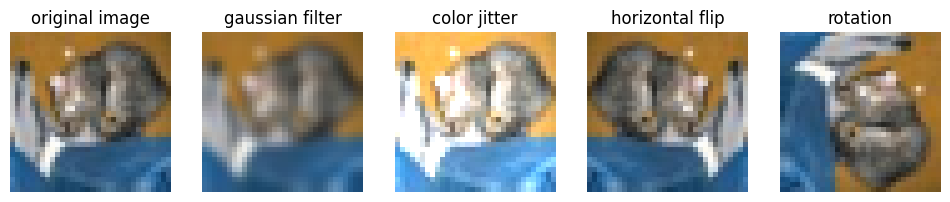

In [ ]:
"""
Visualize how the augmentations are applied to a single image.

Do NOT modify.
"""

raw_test = datasets.CIFAR10(root="./CIFAR_10", train=False, download=True)

f, ax = plt.subplots(1, 5)
f.set_size_inches(12, 3)
x = raw_test[0][0]
x = np.array(x)
g = gaussian_smoothing(x)
j = color_jitter(x)
h = horizontal_flip(x)
r = rot90(x)
title = ['original image', 'gaussian filter', 'color jitter', 'horizontal flip', 'rotation']
for i, img in enumerate([x, g, j, h, r]):
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(title[i], color='k')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, train, prob=0.5, data_dir="./CIFAR_10"):
        """
        Do NOT modify this method.
        """
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.prob = prob

    def __len__(self):
        """
        Do NOT modify this method.
        """
        return len(self.data)
    
    def transform(self, image):
        """
        Apply stochastic data augmentation to the given image.

        Question (d)
        - Convert the given RGB image into BGR scale using opencv library.
        - Apply random augmentation (gaussian smoothing, color jitter, horizontal flip & rotation).
        - Random augmentation is applied with the probability of self.prob.
        - If self.prob = 0.5, 5 out of 10 images will be augmented on average.
        - Convert the augmented image back to RGB scale for training.

        Inputs
        - image: numpy array of an input image of shape (32,32,3).
        Returns
        - image: numpy array of the augmented input image with shape (32,32,3).
        """
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        ##### YOUR CODE #####
        augment_pool = [gaussian_smoothing, color_jitter, horizontal_flip, rot90]
        augment = augment_pool[np.random.randint(len(augment_pool))] # select one randomly from the pool
        image = augment(image) if np.random.randn() < self.prob else image # prob보다 작으면 augment, 아니면 원본.
        #####################
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def __getitem__(self, idx):
        """
        Question (e)
        - Get image and label from self.data with given random index.
        - Convert the image from PIL image to numpy array.
        - Transform the image using self.transform method to apply random augmentation.
        - Normalize the transformed image by mapping the range [0, 255] to range [0, 1].
        - Transpose the (H * W * C) format of the image into (C * H * W) format.
          - To be specific, the dimension of the original image is (32, 32, 3).
          - We want the dimension of the transposed image to be (3, 32, 32).
        - Convert preprocessed image into PyTorch float tensor.
        - Convert label into PyTorch long tensor.
        - Do NOT use torchvision.transforms library!

        Inputs
        - random index of dataset

        Returns
        - processed x & y
        """

        x, y = self.data[idx]

        ##### YOUR CODE #####
        x = np.array(x) # PIL -> np.array # 32,32, 3

        x = self.transform(x)
        x = x/255.0 #normalize
        x = np.transpose(x, (2, 0, 1)) # (H * W * C) -> (C, H, W)
        x = torch.tensor(x).float() #torch.FloatTensor(x) # to float tensor
        y = torch.tensor(y).long() #torch.LongTensor([y])
        
        #####################
        return x, y

Files already downloaded and verified


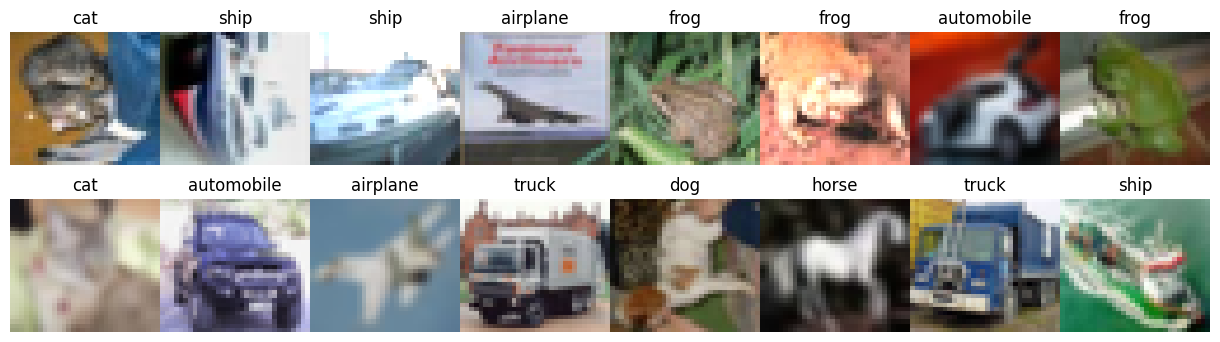

In [ ]:
"""
Plot some example images and class labels without applying data augmentation.

Do NOT modify.
"""

raw_test_dataset = CustomDataset(train=False, prob=0, data_dir="./CIFAR_10")
raw_test_loader = DataLoader(dataset=raw_test_dataset, batch_size=16, shuffle=False)

plot_dataset(raw_test_loader)

Files already downloaded and verified
Files already downloaded and verified


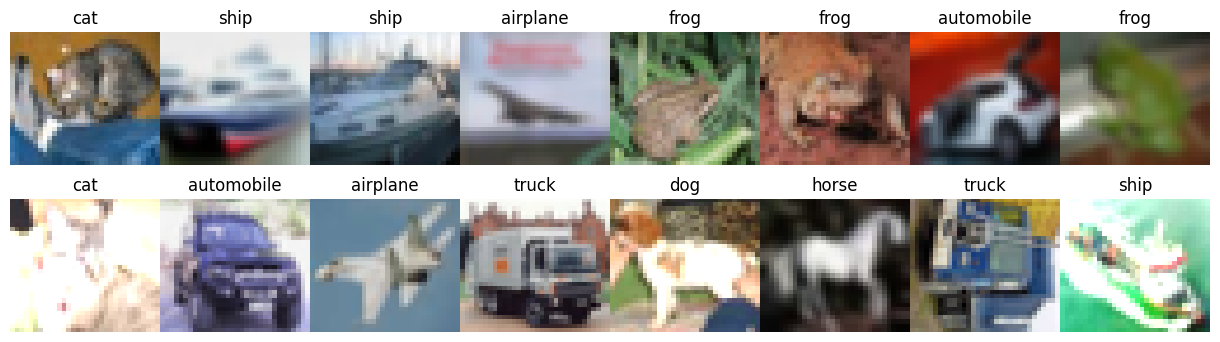

In [ ]:
"""
Same examples after applying data augmentation with 50% probability.
If your transform (c) and collate_fn (d) methods have been implemented well, some of the results should look different from the ones above.

Do NOT modify.
"""

train_dataset = CustomDataset(train=True, prob=0.5)
test_dataset = CustomDataset(train=False, prob=0.5)

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

plot_dataset(test_loader)

# ConvNet Image Classification

In [ ]:
### 
# Question (e)
# Train your ConvNet to achieve test accuracy above 70%
# You can try or add other training options such as SGD or callbacks to schedule learning rates if you want.
###

In [ ]:
class ConvNet(nn.Module):
    """
    Builds a ConvNet model.

    Question (e)
    - Train your ConvNet to achieve test accuracy above 65%
    - things that might be useful...
    - stack [Conv2D + Conv2D + MaxPool2D] at least three times, 
    - follwed by at least three Linear layers.
    - 3x3 filter is enough, but feel free to use larger filter size.
    - channels used: [10, 32, 64, 128, 256, 512, 1024]
    - you can choose smaller or larger channel size as well.
    - The model may include BatchNormalization, regularizers, and Dropout, but they are not necessary.
    """

    def __init__(self):
        """
        Define the layers that you would like to use in your model.
        """
        super(ConvNet, self).__init__()

        ##### YOUR CODE #####
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    
    def forward(self, x):
        """
        Apply forward pass of the given batch of input images.
        Inputs
        - x: batch of input images.
        Returns
        - Layer before softmax, i.e. matrix size of [Batch x number of class]
        """

        ##### YOUR CODE #####
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #####################

        return x

In [ ]:
"""
Make sure your runtime type is GPU and you are using PyTorch version higher than 1.8!

Do NOT modify.
"""

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 2.0.1+cu118, Device: cuda


In [ ]:
"""
Load your customized model "ConvNet" and its training settings.
You may choose the number of epochs that you would like to train.
You might want to use different optimizers or learning rates.
"""

EPOCHS = 20
model = ConvNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_fe

In [ ]:
"""
Train your model "ConvNet" with the augmented CIFAR-10 dataset.
Upon successful training, test accuracy of your model should be above 65%.

Do NOT modify.
"""

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print("\n[EPOCH: {}], \tModel: ConvNet, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: ConvNet, 	Test Loss: 0.0266, 	Test Accuracy: 38.30 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: ConvNet, 	Test Loss: 0.0249, 	Test Accuracy: 42.03 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: ConvNet, 	Test Loss: 0.0229, 	Test Accuracy: 46.71 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: ConvNet, 	Test Loss: 0.0219, 	Test Accuracy: 49.85 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: ConvNet, 	Test Loss: 0.0206, 	Test Accuracy: 52.60 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: ConvNet, 	Test Loss: 0.0194, 	Test Accuracy: 55.53 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: ConvNet, 	Test Loss: 0.0189, 	Test Accuracy: 57.13 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: ConvNet, 	Test Loss: 0.0182, 	Test Accuracy: 58.90 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: ConvNet, 	Test Loss: 0.0174, 	Test Accuracy: 60.11 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: ConvNet, 	Test Loss: 0.0164, 	Test Accuracy: 63.35 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 11], 	Model: ConvNet, 	Test Loss: 0.0164, 	Test Accuracy: 63.15 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 12], 	Model: ConvNet, 	Test Loss: 0.0156, 	Test Accuracy: 64.88 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 13], 	Model: ConvNet, 	Test Loss: 0.0150, 	Test Accuracy: 66.37 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 14], 	Model: ConvNet, 	Test Loss: 0.0148, 	Test Accuracy: 66.46 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 15], 	Model: ConvNet, 	Test Loss: 0.0146, 	Test Accuracy: 67.46 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 16], 	Model: ConvNet, 	Test Loss: 0.0151, 	Test Accuracy: 66.80 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 17], 	Model: ConvNet, 	Test Loss: 0.0143, 	Test Accuracy: 68.57 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 18], 	Model: ConvNet, 	Test Loss: 0.0139, 	Test Accuracy: 69.27 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 19], 	Model: ConvNet, 	Test Loss: 0.0140, 	Test Accuracy: 69.38 % 



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 20], 	Model: ConvNet, 	Test Loss: 0.0133, 	Test Accuracy: 71.25 % 

